In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import warnings
warnings.filterwarnings('ignore')

***Data Preprocessing***

In [3]:
# Loading the dataset
df = pd.read_csv('heart.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst look at the data:")
df.head()
print("Column names and data types:")
print(df.dtypes)
print("Heart Disease distribution:")


Dataset loaded successfully!
Shape: (918, 12)

First look at the data:
Column names and data types:
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object
Heart Disease distribution:


In [5]:
print("Basic dataset information")
print("Dataset shape:", df.shape)
print("Number of patients:", df.shape[0])
print("Number of features:", df.shape[1])

Basic dataset information
Dataset shape: (918, 12)
Number of patients: 918
Number of features: 12


In [7]:
df = pd.read_csv('heart.csv')
print("Dataset loaded successfully")
print("Shape:", df.shape)
print("\nFirst look at the data:")
print(df.head())
print("\nTarget variable distribution:")
print(df['HeartDisease'].value_counts())

Dataset loaded successfully
Shape: (918, 12)

First look at the data:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Target variable distribution:
HeartDisease
1    508
0    410
Name: count, dtype: int64


In [9]:
print("\nBasic summary")
print(df.describe())


Basic summary
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  


In [11]:
# Seperating the Features and Target Labels
heartFeature = df.iloc[:, :-1]
heartTarget = df.iloc[:, -1]
print("Features data")
print(heartFeature.head())
print("Target labels")
print(heartTarget.head())

Features data
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  
0              N      0.0       Up  
1              N      1.0     Flat  
2              N      0.0       Up  
3              Y      1.5     Flat  
4              N      0.0       Up  
Target labels
0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64


In [13]:
print("Data types in the dataset")
print(df.dtypes)
print("\nCategorical columns found")
cat_cols = df.select_dtypes(include='object').columns
print(cat_cols)
print("\nNumerical columns found") 
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = num_cols.drop('HeartDisease')
print(num_cols)
print("\nSample of categorical data")
for col in cat_cols:
    print(f"{col}: {df[col].unique()}")

Data types in the dataset
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Categorical columns found
Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

Numerical columns found
Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')

Sample of categorical data
Sex: ['M' 'F']
ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
RestingECG: ['Normal' 'ST' 'LVH']
ExerciseAngina: ['N' 'Y']
ST_Slope: ['Up' 'Flat' 'Down']


In [15]:
heart_data_encoded = heartFeature.copy()
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for column in categorical_columns:
    encoder = LabelEncoder()
    heart_data_encoded[column] = encoder.fit_transform(heart_data_encoded[column])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(heart_data_encoded)
scaled_features_df = pd.DataFrame(scaled_data, columns=heart_data_encoded.columns)
print("Scaled features:")
print(scaled_features_df.head())

Scaled features:
        Age       Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0 -1.433140  0.515952       0.229032   0.410909     0.825070  -0.551341   
1 -0.478484 -1.938163       1.275059   1.491752    -0.171961  -0.551341   
2 -1.751359  0.515952       0.229032  -0.129513     0.770188  -0.551341   
3 -0.584556 -1.938163      -0.816995   0.302825     0.139040  -0.551341   
4  0.051881  0.515952       1.275059   0.951331    -0.034755  -0.551341   

   RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  
0    0.017255  1.382928       -0.823556 -0.832432  1.052114  
1    0.017255  0.754157       -0.823556  0.105664 -0.596078  
2    1.601219 -1.525138       -0.823556 -0.832432  1.052114  
3    0.017255 -1.132156        1.214246  0.574711 -0.596078  
4    0.017255 -0.581981       -0.823556 -0.832432  1.052114  


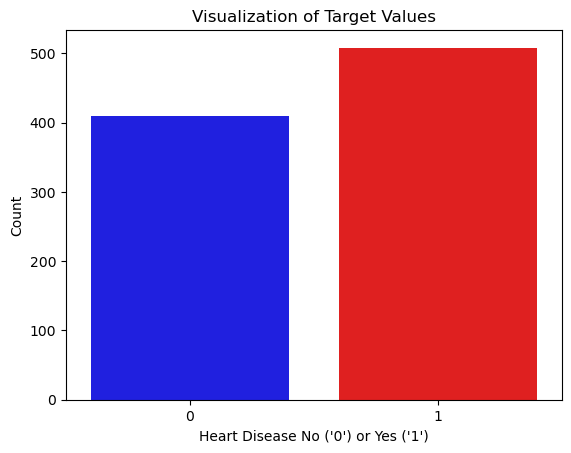

In [17]:
# Visualization of Target Labels
sns.countplot(x=heartTarget, palette=["blue", "red"])
plt.title("Visualization of Target Values")
plt.xlabel("Heart Disease No ('0') or Yes ('1')")
plt.ylabel("Count")
plt.show()
print()

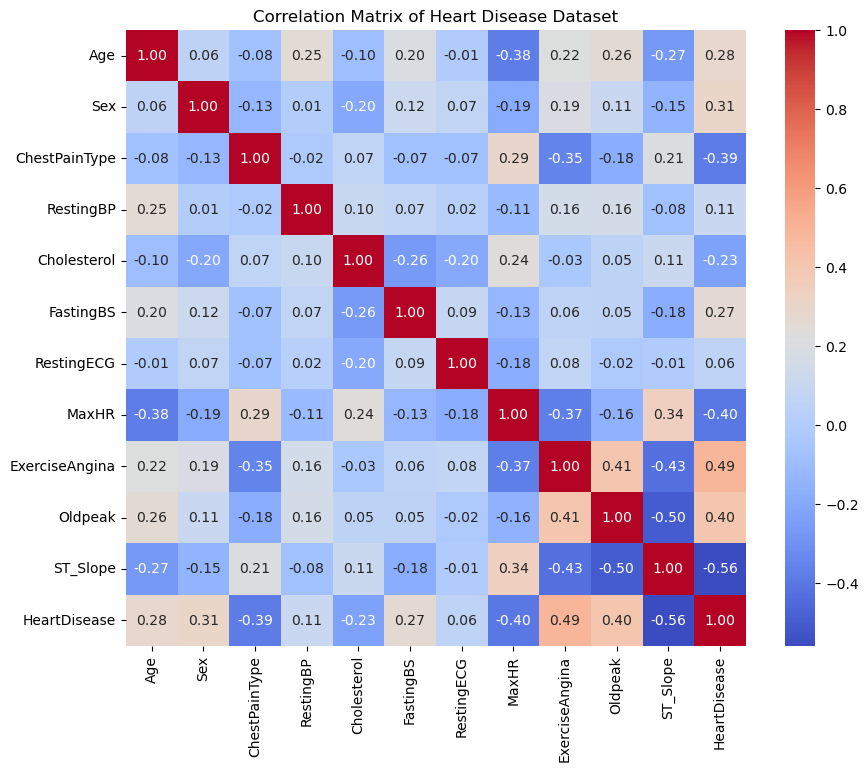

In [19]:
df_encoded = df.copy()
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for column in categorical_columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Heart Disease Dataset')
plt.show()

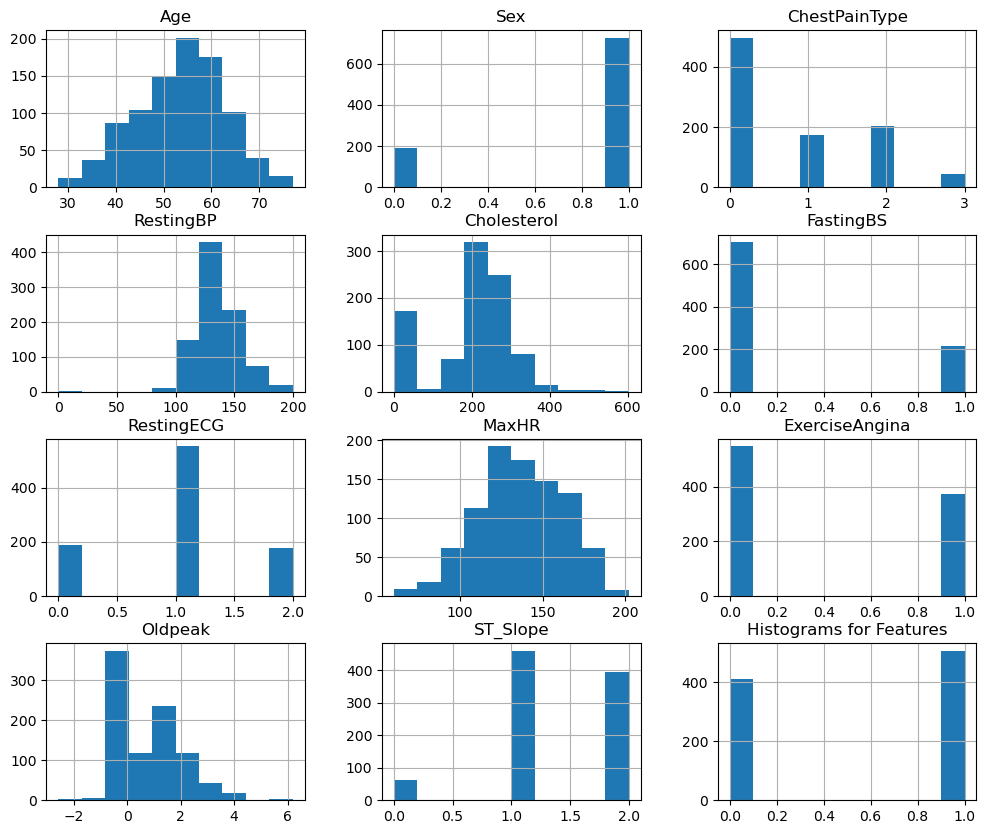

In [21]:
df_encoded.hist(figsize=(12, 10))
plt.title('Histograms for Features')
plt.show()


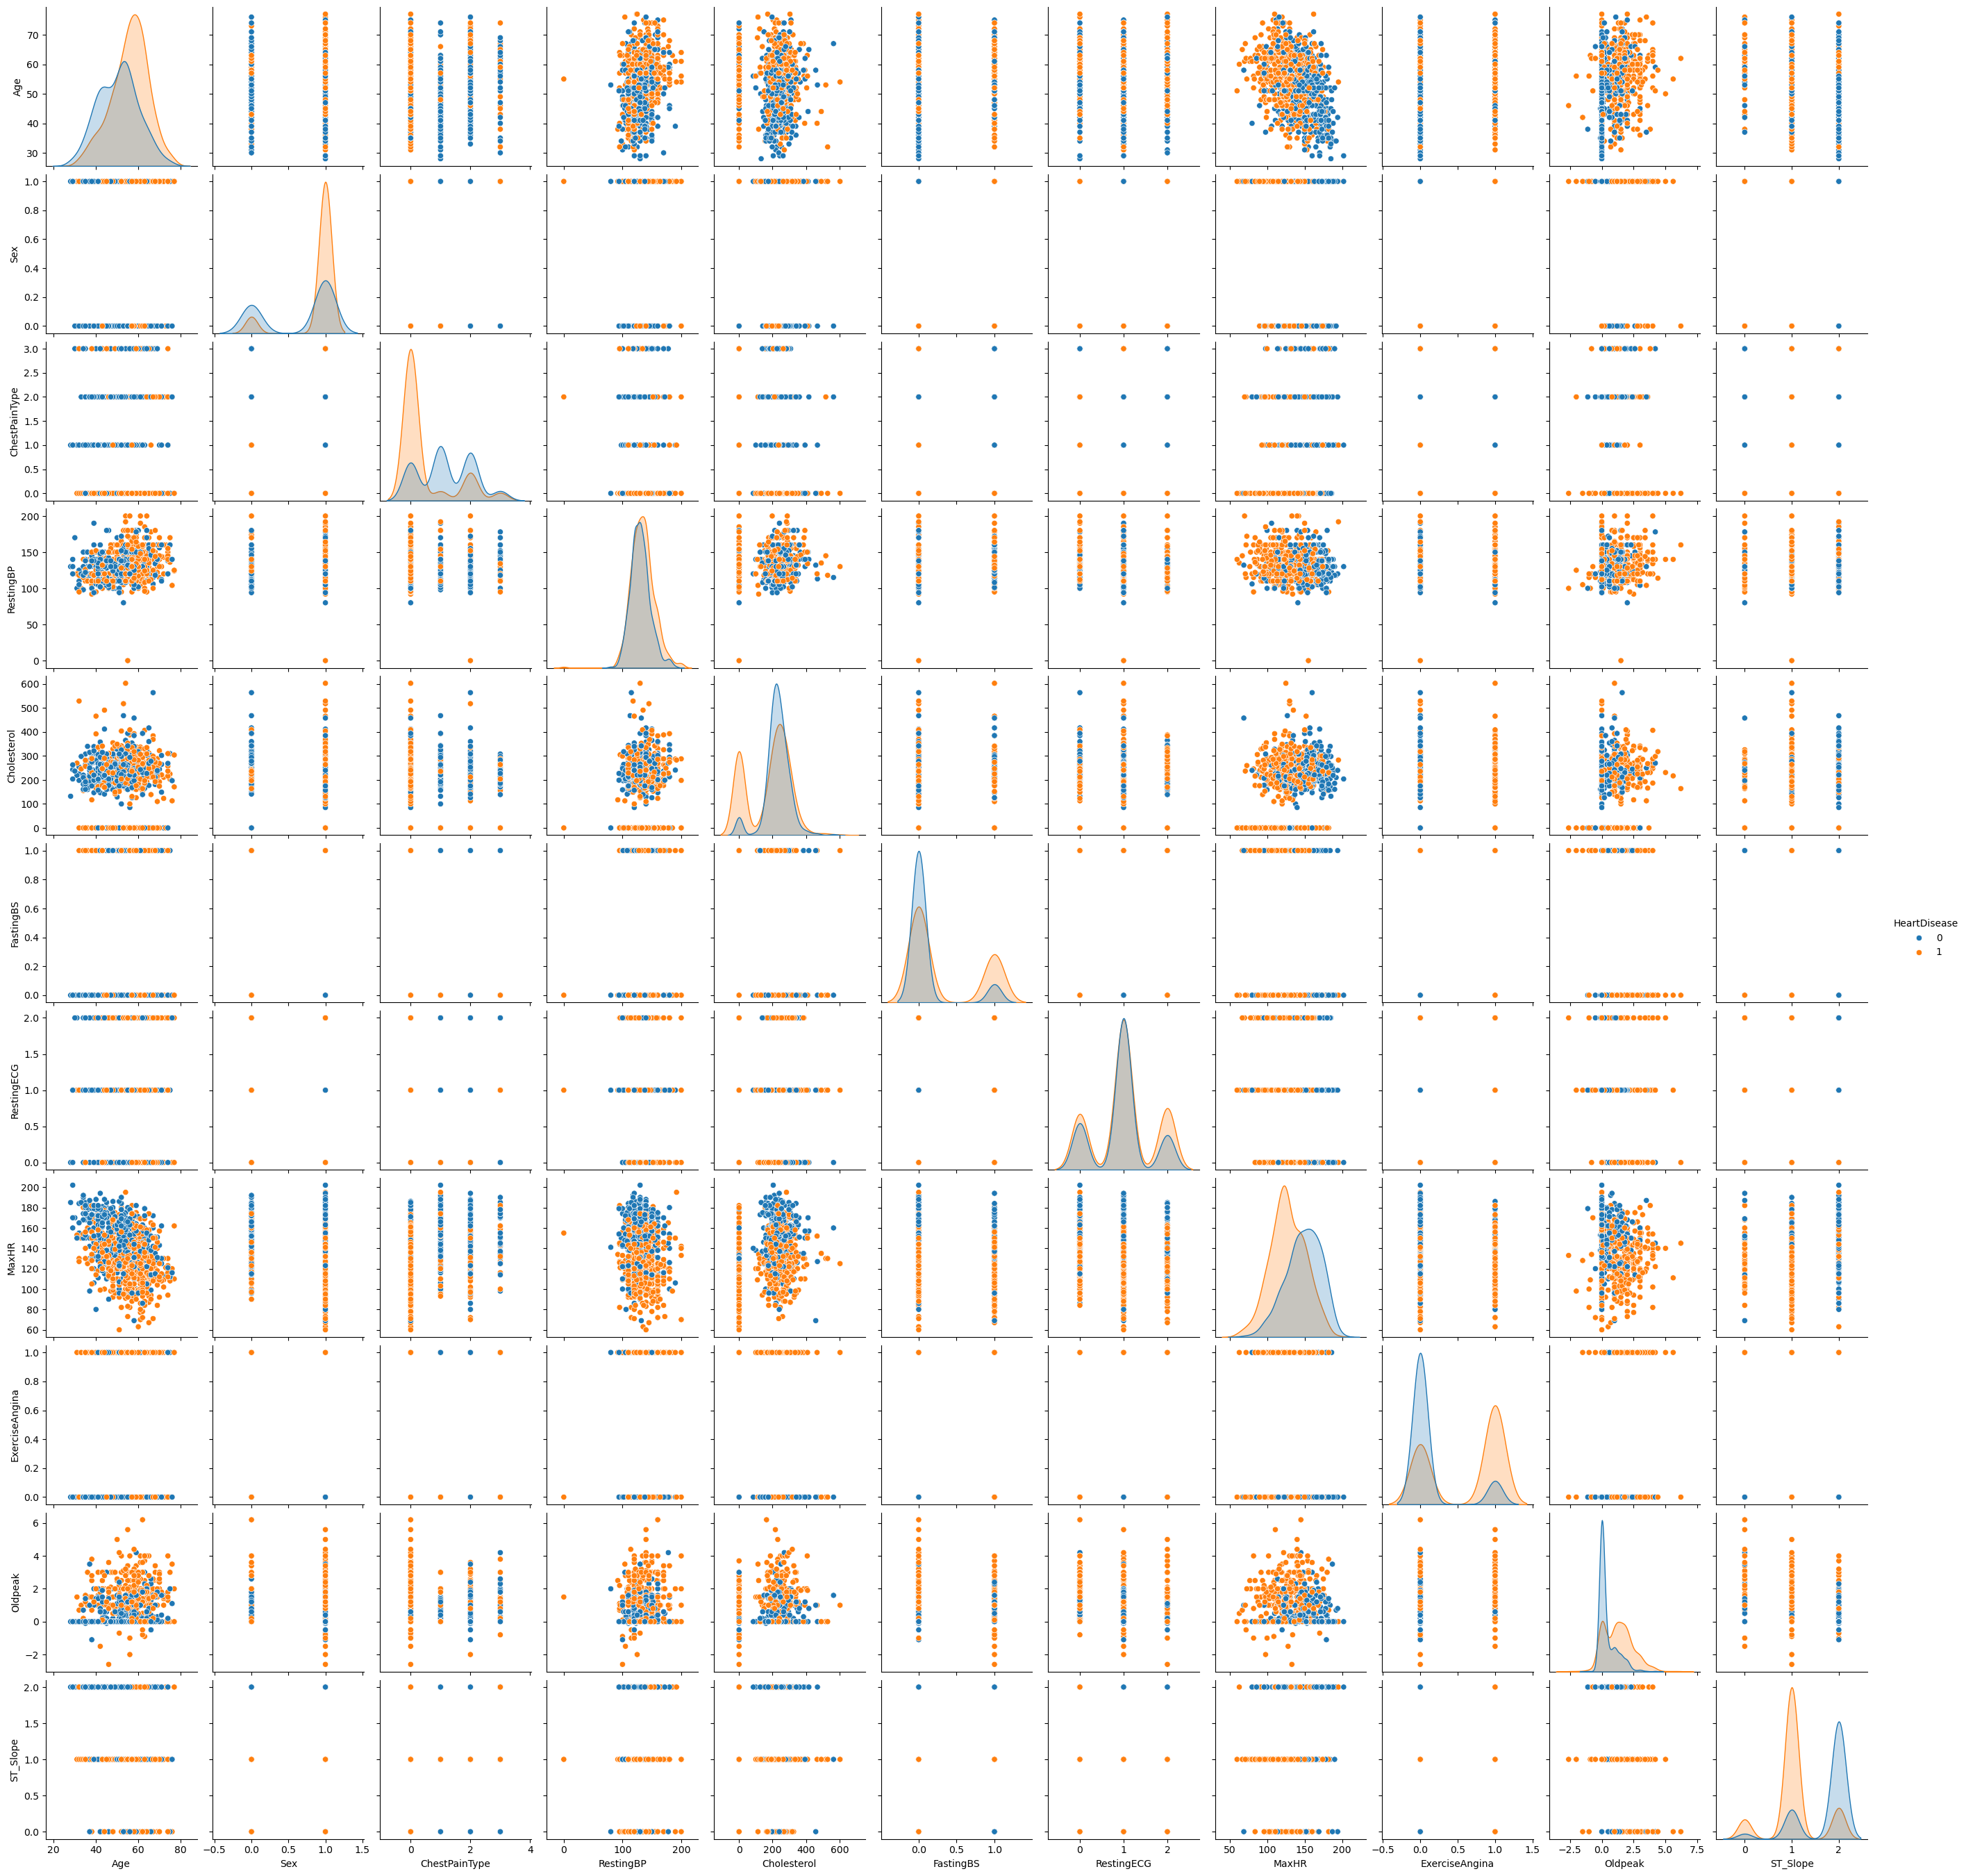

In [23]:
sns.pairplot(df_encoded, hue='HeartDisease')
plt.show()

In [25]:
# Encode the categorical data
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
encoded_data = heartFeature.copy()
for col in cat_cols:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col])
print("Categorical encoding done")
print(encoded_data.head())

Categorical encoding done
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              0        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  
0    172               0      0.0         2  
1    156               0      1.0         1  
2     98               0      0.0         2  
3    108               1      1.5         1  
4    122               0      0.0         2  


***10-fold cross-validation***

In [27]:
 # Set up 10 fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_num = 1
print("Starting 10-fold cross validation")
print("Number of folds: 10")
print("Shuffle: True")
print("Random state: 42")
for train_index, test_index in kf.split(heartFeature):
    print(f"Fold {fold_num}:")
    print(f"Training samples: {len(train_index)}")
    print(f"Testing samples: {len(test_index)}")
    fold_num += 1


Starting 10-fold cross validation
Number of folds: 10
Shuffle: True
Random state: 42
Fold 1:
Training samples: 826
Testing samples: 92
Fold 2:
Training samples: 826
Testing samples: 92
Fold 3:
Training samples: 826
Testing samples: 92
Fold 4:
Training samples: 826
Testing samples: 92
Fold 5:
Training samples: 826
Testing samples: 92
Fold 6:
Training samples: 826
Testing samples: 92
Fold 7:
Training samples: 826
Testing samples: 92
Fold 8:
Training samples: 826
Testing samples: 92
Fold 9:
Training samples: 827
Testing samples: 91
Fold 10:
Training samples: 827
Testing samples: 91


In [29]:
# Final preprocessed data
X_ready = encoded_data
y_ready = heartTarget
print("Data preprocessing completed")
print("Features shape:", X_ready.shape)
print("Target shape:", y_ready.shape)

Data preprocessing completed
Features shape: (918, 11)
Target shape: (918,)


***Random Forest***

In [31]:
# Start with random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_results = []
print("Random Forest - 10 fold cross validation")
print("Starting training...")
fold_count = 1
for train_idx, test_idx in kf.split(X_ready):
    X_train, X_test = X_ready.iloc[train_idx], X_ready.iloc[test_idx]
    y_train, y_test = y_ready.iloc[train_idx], y_ready.iloc[test_idx]
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    print(f"Fold {fold_count} completed")
    fold_count += 1

Random Forest - 10 fold cross validation
Starting training...
Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed
Fold 6 completed
Fold 7 completed
Fold 8 completed
Fold 9 completed
Fold 10 completed


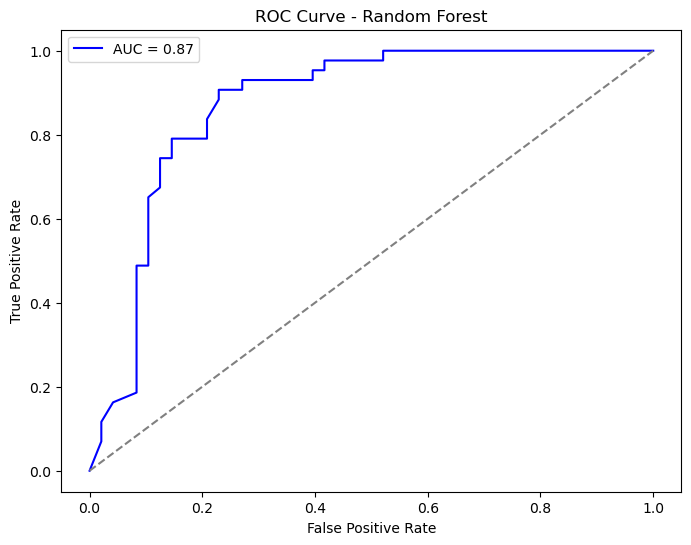

In [33]:
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

In [35]:
# Calculate metrics for Random Forest model 
rf_model = RandomForestClassifier(random_state=42)
rf_metrics = []
print("Random Forest - 10 fold cross validation")
fold_count = 1
for train_idx, test_idx in kf.split(X_ready):
    X_train, X_test = X_ready.iloc[train_idx], X_ready.iloc[test_idx]
    y_train, y_test = y_ready.iloc[train_idx], y_ready.iloc[test_idx]
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    p = tp + fn
    n = tn + fp
    tpr = tp / p if p > 0 else 0
    tnr = tn / n if n > 0 else 0
    fpr = fp / n if n > 0 else 0
    fnr = fn / p if p > 0 else 0
    accuracy = (tp + tn) / (p + n)
    balanced_acc = (tpr + tnr) / 2
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tpr
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    error_rate = (fp + fn) / (p + n)
    tss = tpr - fpr
    hss_denom = (tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)
    hss = 2 * (tp * tn - fp * fn) / hss_denom if hss_denom > 0 else 0
    bs = np.mean((y_prob - y_test) ** 2)
    print(f"Fold {fold_count} - TP:{tp} TN:{tn} FP:{fp} FN:{fn} Acc:{accuracy:.3f}")
    fold_result = {
        'fold': fold_count,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'p': p, 'n': n,
        'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr,
        'accuracy': accuracy, 'balanced_accuracy': balanced_acc,
        'precision': precision, 'recall': recall, 'f1': f1, 'error_rate': error_rate,
        'tss': tss, 'hss': hss,
        'bs': bs,
        'y_true': y_test, 'y_prob': y_prob
    }
    rf_metrics.append(fold_result)
    fold_count += 1

Random Forest - 10 fold cross validation
Fold 1 - TP:50 TN:33 FP:5 FN:4 Acc:0.902
Fold 2 - TP:45 TN:36 FP:3 FN:8 Acc:0.880
Fold 3 - TP:53 TN:31 FP:4 FN:4 Acc:0.913
Fold 4 - TP:49 TN:28 FP:7 FN:8 Acc:0.837
Fold 5 - TP:44 TN:41 FP:6 FN:1 Acc:0.924
Fold 6 - TP:47 TN:31 FP:10 FN:4 Acc:0.848
Fold 7 - TP:44 TN:33 FP:9 FN:6 Acc:0.837
Fold 8 - TP:42 TN:32 FP:10 FN:8 Acc:0.804
Fold 9 - TP:46 TN:38 FP:5 FN:2 Acc:0.923
Fold 10 - TP:40 TN:34 FP:14 FN:3 Acc:0.813


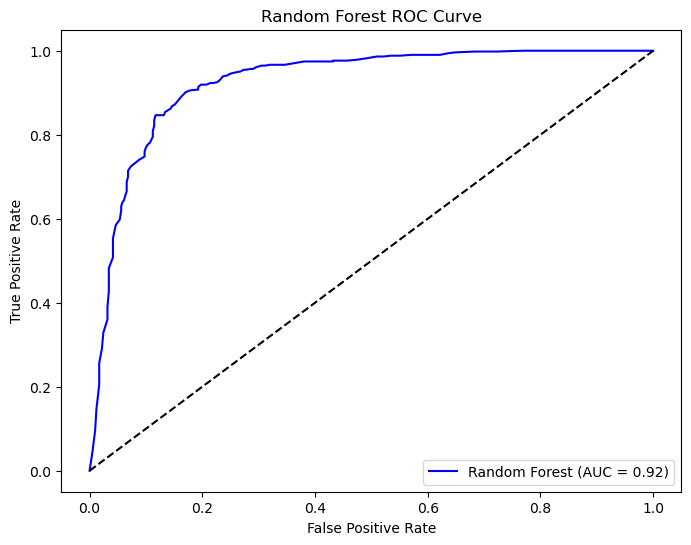

In [37]:
# Random Forest ROC curve
plt.figure(figsize=(8, 6))
all_y_true = []
all_y_prob = []
for fold in rf_metrics:
    all_y_true.extend(fold['y_true'])
    all_y_prob.extend(fold['y_prob'])
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.show()

In [39]:
# Random Forest results
print("Random Forest Results")
for fold in rf_metrics:
    fpr, tpr, _ = roc_curve(fold['y_true'], fold['y_prob'])
    auc_score = auc(fpr, tpr)
    p = fold['tp'] + fold['fn']
    n = fold['tn'] + fold['fp']
    error_rate = (fold['fp'] + fold['fn']) / (p + n)
    climatology = np.mean(y_ready)
    bs_climatology = np.mean((climatology - fold['y_true']) ** 2)
    bss = 1 - (fold['bs'] / bs_climatology) if bs_climatology > 0 else 0
    print(f"Fold {fold['fold']}: TP:{fold['tp']} TN:{fold['tn']} FP:{fold['fp']} FN:{fold['fn']} P:{p} N:{n}")
    print(f"TPR:{fold['tpr']:.3f} TNR:{fold['tnr']:.3f} FPR:{fold['fpr']:.3f} FNR:{fold['fnr']:.3f}")
    print(f"Acc:{fold['accuracy']:.3f} BalAcc:{fold['balanced_accuracy']:.3f} Err:{error_rate:.3f}")
    print(f"Prec:{fold['precision']:.3f} Rec:{fold['recall']:.3f} F1:{fold['f1']:.3f}")
    print(f"TSS:{fold['tss']:.3f} HSS:{fold['hss']:.3f} BS:{fold['bs']:.3f} BSS:{bss:.3f} AUC:{auc_score:.3f}")
    print()
print("Average Results:")
avg_acc = sum([f['accuracy'] for f in rf_metrics]) / len(rf_metrics)
avg_f1 = sum([f['f1'] for f in rf_metrics]) / len(rf_metrics)
avg_bs = sum([f['bs'] for f in rf_metrics]) / len(rf_metrics)
avg_auc = sum([auc(roc_curve(f['y_true'], f['y_prob'])[0], roc_curve(f['y_true'], f['y_prob'])[1]) for f in rf_metrics]) / len(rf_metrics)

print(f"Accuracy: {avg_acc:.3f}")
print(f"F1 Score: {avg_f1:.3f}")
print(f"Brier Score: {avg_bs:.3f}")
print(f"AUC: {avg_auc:.3f}")


Random Forest Results
Fold 1: TP:50 TN:33 FP:5 FN:4 P:54 N:38
TPR:0.926 TNR:0.868 FPR:0.132 FNR:0.074
Acc:0.902 BalAcc:0.897 Err:0.098
Prec:0.909 Rec:0.926 F1:0.917
TSS:0.794 HSS:0.797 BS:0.097 BSS:0.602 AUC:0.946

Fold 2: TP:45 TN:36 FP:3 FN:8 P:53 N:39
TPR:0.849 TNR:0.923 FPR:0.077 FNR:0.151
Acc:0.880 BalAcc:0.886 Err:0.120
Prec:0.938 Rec:0.849 F1:0.891
TSS:0.772 HSS:0.759 BS:0.093 BSS:0.618 AUC:0.945

Fold 3: TP:53 TN:31 FP:4 FN:4 P:57 N:35
TPR:0.930 TNR:0.886 FPR:0.114 FNR:0.070
Acc:0.913 BalAcc:0.908 Err:0.087
Prec:0.930 Rec:0.930 F1:0.930
TSS:0.816 HSS:0.816 BS:0.072 BSS:0.701 AUC:0.966

Fold 4: TP:49 TN:28 FP:7 FN:8 P:57 N:35
TPR:0.860 TNR:0.800 FPR:0.200 FNR:0.140
Acc:0.837 BalAcc:0.830 Err:0.163
Prec:0.875 Rec:0.860 F1:0.867
TSS:0.660 HSS:0.656 BS:0.109 BSS:0.547 AUC:0.928

Fold 5: TP:44 TN:41 FP:6 FN:1 P:45 N:47
TPR:0.978 TNR:0.872 FPR:0.128 FNR:0.022
Acc:0.924 BalAcc:0.925 Err:0.076
Prec:0.880 Rec:0.978 F1:0.926
TSS:0.850 HSS:0.848 BS:0.078 BSS:0.693 AUC:0.952

Fold 6: TP:47

***LSTM***

In [43]:
# Calculate metrics for LSTM
lstm_metrics = []
fold_num = 1
for train_idx, test_idx in kf.split(X_ready):
    print("Fold", fold_num)
    X_train, X_test = X_ready.iloc[train_idx], X_ready.iloc[test_idx]
    y_train, y_test = y_ready.iloc[train_idx], y_ready.iloc[test_idx]
    X_train_rs = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_rs = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.fit(X_train_rs, y_train, epochs=50, batch_size=32, verbose=0)
    y_prob = model.predict(X_test_rs).flatten()
    y_pred = (y_prob > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    p = tp + fn
    n = tn + fp
    tpr = tp / p if p > 0 else 0
    tnr = tn / n if n > 0 else 0
    fpr = fp / n if n > 0 else 0
    fnr = fn / p if p > 0 else 0
    accuracy = (tp + tn) / (p + n)
    balanced_acc = (tpr + tnr) / 2
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tpr
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    error_rate = (fp + fn) / (p + n)
    tss = tpr - fpr
    hss_denom = (tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)
    hss = 2 * (tp * tn - fp * fn) / hss_denom if hss_denom > 0 else 0
    # Calculate brier score
    bs = np.mean((y_prob - y_test) ** 2)
    print(f"TP:{tp} TN:{tn} FP:{fp} FN:{fn} Acc:{accuracy:.3f}")
    lstm_metrics.append({
        'fold': fold_num,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'p': p, 'n': n,
        'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr,
        'accuracy': accuracy, 'balanced_accuracy': balanced_acc,
        'precision': precision, 'recall': recall, 'f1': f1, 'error_rate': error_rate,
        'tss': tss, 'hss': hss,
        'bs': bs,
        'y_true': y_test, 'y_prob': y_prob
    })
    fold_num += 1

Fold 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
TP:47 TN:29 FP:9 FN:7 Acc:0.826
Fold 2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
TP:42 TN:35 FP:4 FN:11 Acc:0.837
Fold 3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
TP:53 TN:32 FP:3 FN:4 Acc:0.924
Fold 4
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
TP:46 TN:29 FP:6 FN:11 Acc:0.815
Fold 5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
TP:39 TN:39 FP:8 FN:6 Acc:0.848
Fold 6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
TP:46 TN:35 FP:6 FN:5 Acc:0.880
Fold 7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
TP:38 TN:34 FP:8 FN:12 Acc:0.783
Fold 8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
TP:38 TN:34 FP:8 FN:12 Acc:0.783
Fold 9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
TP:43 TN:39 FP:4 FN:5 Acc:0.901
Fold 10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
TP:40 TN:35 FP:13 FN:3 Acc:0.824


In [45]:
print("LSTM - 10 fold cross validation: ")
for fold in lstm_metrics:
    print(f"Fold {fold['fold']}: TP:{fold['tp']} TN:{fold['tn']} FP:{fold['fp']} FN:{fold['fn']} Acc:{fold['accuracy']:.3f}")
print("\nAverage metrics:")
avg_acc = sum([f['accuracy'] for f in lstm_metrics]) / len(lstm_metrics)
avg_f1 = sum([f['f1'] for f in lstm_metrics]) / len(lstm_metrics)
avg_prec = sum([f['precision'] for f in lstm_metrics]) / len(lstm_metrics)
avg_rec = sum([f['recall'] for f in lstm_metrics]) / len(lstm_metrics)
print(f"Accuracy: {avg_acc:.3f}")
print(f"F1 Score: {avg_f1:.3f}")
print(f"Precision: {avg_prec:.3f}")
print(f"Recall: {avg_rec:.3f}")

LSTM - 10 fold cross validation: 
Fold 1: TP:47 TN:29 FP:9 FN:7 Acc:0.826
Fold 2: TP:42 TN:35 FP:4 FN:11 Acc:0.837
Fold 3: TP:53 TN:32 FP:3 FN:4 Acc:0.924
Fold 4: TP:46 TN:29 FP:6 FN:11 Acc:0.815
Fold 5: TP:39 TN:39 FP:8 FN:6 Acc:0.848
Fold 6: TP:46 TN:35 FP:6 FN:5 Acc:0.880
Fold 7: TP:38 TN:34 FP:8 FN:12 Acc:0.783
Fold 8: TP:38 TN:34 FP:8 FN:12 Acc:0.783
Fold 9: TP:43 TN:39 FP:4 FN:5 Acc:0.901
Fold 10: TP:40 TN:35 FP:13 FN:3 Acc:0.824

Average metrics:
Accuracy: 0.842
F1 Score: 0.855
Precision: 0.862
Recall: 0.851


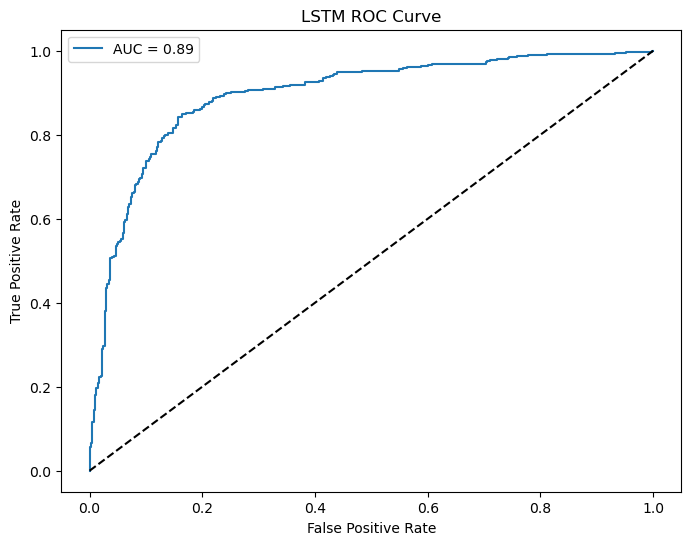

In [81]:
# LSTM ROC Curve
plt.figure(figsize=(8, 6))
all_true = []
all_prob = []
for fold in lstm_metrics:
    all_true.extend(fold['y_true'])
    all_prob.extend(fold['y_prob'])
fpr, tpr, _ = roc_curve(all_true, all_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC Curve')
plt.legend()
plt.show()

In [47]:
# LSTM results
print("LSTM Results")
for fold in lstm_metrics:
    fpr, tpr, _ = roc_curve(fold['y_true'], fold['y_prob'])
    auc_score = auc(fpr, tpr)
    p = fold['tp'] + fold['fn']
    n = fold['tn'] + fold['fp']
    error_rate = (fold['fp'] + fold['fn']) / (p + n)
    climatology = np.mean(y_ready)
    bs_climatology = np.mean((climatology - fold['y_true']) ** 2)
    bss = 1 - (fold['bs'] / bs_climatology) if bs_climatology > 0 else 0
    print(f"Fold {fold['fold']}: TP:{fold['tp']} TN:{fold['tn']} FP:{fold['fp']} FN:{fold['fn']} P:{p} N:{n}")
    print(f"TPR:{fold['tpr']:.3f} TNR:{fold['tnr']:.3f} FPR:{fold['fpr']:.3f} FNR:{fold['fnr']:.3f}")
    print(f"Acc:{fold['accuracy']:.3f} BalAcc:{fold['balanced_accuracy']:.3f} Err:{error_rate:.3f}")
    print(f"Prec:{fold['precision']:.3f} Rec:{fold['recall']:.3f} F1:{fold['f1']:.3f}")
    print(f"TSS:{fold['tss']:.3f} HSS:{fold['hss']:.3f} BS:{fold['bs']:.3f} BSS:{bss:.3f} AUC:{auc_score:.3f}")
    print()

print("Average Results:")
avg_acc = sum([f['accuracy'] for f in lstm_metrics]) / len(lstm_metrics)
avg_f1 = sum([f['f1'] for f in lstm_metrics]) / len(lstm_metrics)
avg_bs = sum([f['bs'] for f in lstm_metrics]) / len(lstm_metrics)
avg_auc = sum([auc(roc_curve(f['y_true'], f['y_prob'])[0], roc_curve(f['y_true'], f['y_prob'])[1]) for f in lstm_metrics]) / len(lstm_metrics)
print(f"Accuracy: {avg_acc:.3f}")
print(f"F1 Score: {avg_f1:.3f}")
print(f"Brier Score: {avg_bs:.3f}")
print(f"AUC: {avg_auc:.3f}")

LSTM Results
Fold 1: TP:47 TN:29 FP:9 FN:7 P:54 N:38
TPR:0.870 TNR:0.763 FPR:0.237 FNR:0.130
Acc:0.826 BalAcc:0.817 Err:0.174
Prec:0.839 Rec:0.870 F1:0.855
TSS:0.634 HSS:0.639 BS:0.129 BSS:0.470 AUC:0.895

Fold 2: TP:42 TN:35 FP:4 FN:11 P:53 N:39
TPR:0.792 TNR:0.897 FPR:0.103 FNR:0.208
Acc:0.837 BalAcc:0.845 Err:0.163
Prec:0.913 Rec:0.792 F1:0.848
TSS:0.690 HSS:0.674 BS:0.139 BSS:0.432 AUC:0.885

Fold 3: TP:53 TN:32 FP:3 FN:4 P:57 N:35
TPR:0.930 TNR:0.914 FPR:0.086 FNR:0.070
Acc:0.924 BalAcc:0.922 Err:0.076
Prec:0.946 Rec:0.930 F1:0.938
TSS:0.844 HSS:0.839 BS:0.073 BSS:0.697 AUC:0.963

Fold 4: TP:46 TN:29 FP:6 FN:11 P:57 N:35
TPR:0.807 TNR:0.829 FPR:0.171 FNR:0.193
Acc:0.815 BalAcc:0.818 Err:0.185
Prec:0.885 Rec:0.807 F1:0.844
TSS:0.636 HSS:0.619 BS:0.132 BSS:0.449 AUC:0.888

Fold 5: TP:39 TN:39 FP:8 FN:6 P:45 N:47
TPR:0.867 TNR:0.830 FPR:0.170 FNR:0.133
Acc:0.848 BalAcc:0.848 Err:0.152
Prec:0.830 Rec:0.867 F1:0.848
TSS:0.696 HSS:0.696 BS:0.120 BSS:0.528 AUC:0.901

Fold 6: TP:46 TN:35 

***KNN***

In [49]:
# KNN model training
knn_metrics = []
print("KNN - 10 fold cross validation")
fold_num = 1
for train_idx, test_idx in kf.split(X_ready):
    print("Fold", fold_num)
    X_train, X_test = X_ready.iloc[train_idx], X_ready.iloc[test_idx]
    y_train, y_test = y_ready.iloc[train_idx], y_ready.iloc[test_idx]
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train, y_train)
    y_prob = knn_model.predict_proba(X_test)[:, 1]
    y_pred = knn_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    p = tp + fn
    n = tn + fp
    tpr = tp / p if p > 0 else 0
    tnr = tn / n if n > 0 else 0
    fpr = fp / n if n > 0 else 0
    fnr = fn / p if p > 0 else 0
    accuracy = (tp + tn) / (p + n)
    balanced_acc = (tpr + tnr) / 2
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tpr
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    error_rate = (fp + fn) / (p + n)
    tss = tpr - fpr
    hss_denom = (tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)
    hss = 2 * (tp * tn - fp * fn) / hss_denom if hss_denom > 0 else 0
    bs = np.mean((y_prob - y_test) ** 2)
    print(f"TP:{tp} TN:{tn} FP:{fp} FN:{fn} Acc:{accuracy:.3f}")
    knn_metrics.append({
        'fold': fold_num,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'p': p, 'n': n,
        'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr,
        'accuracy': accuracy, 'balanced_accuracy': balanced_acc,
        'precision': precision, 'recall': recall, 'f1': f1, 'error_rate': error_rate,
        'tss': tss, 'hss': hss,
        'bs': bs,
        'y_true': y_test, 'y_prob': y_prob
    })
    fold_num += 1

KNN - 10 fold cross validation
Fold 1
TP:39 TN:26 FP:12 FN:15 Acc:0.707
Fold 2
TP:39 TN:27 FP:12 FN:14 Acc:0.717
Fold 3
TP:48 TN:24 FP:11 FN:9 Acc:0.783
Fold 4
TP:45 TN:22 FP:13 FN:12 Acc:0.728
Fold 5
TP:32 TN:30 FP:17 FN:13 Acc:0.674
Fold 6
TP:43 TN:28 FP:13 FN:8 Acc:0.772
Fold 7
TP:36 TN:25 FP:17 FN:14 Acc:0.663
Fold 8
TP:34 TN:28 FP:14 FN:16 Acc:0.674
Fold 9
TP:35 TN:28 FP:15 FN:13 Acc:0.692
Fold 10
TP:35 TN:28 FP:20 FN:8 Acc:0.692


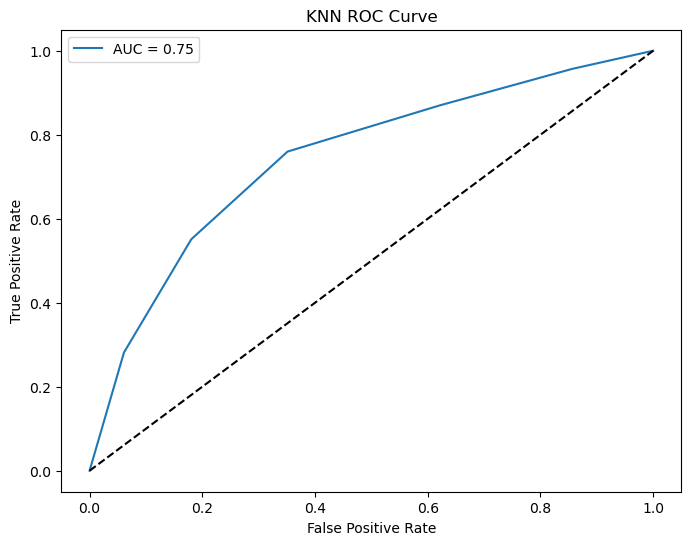

In [51]:
# KNN ROC Curve
plt.figure(figsize=(8, 6))
all_true = []
all_prob = []
for fold in knn_metrics:
    all_true.extend(fold['y_true'])
    all_prob.extend(fold['y_prob'])
fpr, tpr, _ = roc_curve(all_true, all_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend()
plt.show()

In [53]:
# KNN results
print("KNN Results")
for fold in knn_metrics:
    fpr, tpr, _ = roc_curve(fold['y_true'], fold['y_prob'])
    auc_score = auc(fpr, tpr)
    p = fold['tp'] + fold['fn']
    n = fold['tn'] + fold['fp']
    error_rate = (fold['fp'] + fold['fn']) / (p + n)
    climatology = np.mean(y_ready)
    bs_climatology = np.mean((climatology - fold['y_true']) ** 2)
    bss = 1 - (fold['bs'] / bs_climatology) if bs_climatology > 0 else 0
    
    print(f"Fold {fold['fold']}: TP:{fold['tp']} TN:{fold['tn']} FP:{fold['fp']} FN:{fold['fn']} P:{p} N:{n}")
    print(f"TPR:{fold['tpr']:.3f} TNR:{fold['tnr']:.3f} FPR:{fold['fpr']:.3f} FNR:{fold['fnr']:.3f}")
    print(f"Acc:{fold['accuracy']:.3f} BalAcc:{fold['balanced_accuracy']:.3f} Err:{error_rate:.3f}")
    print(f"Prec:{fold['precision']:.3f} Rec:{fold['recall']:.3f} F1:{fold['f1']:.3f}")
    print(f"TSS:{fold['tss']:.3f} HSS:{fold['hss']:.3f} BS:{fold['bs']:.3f} BSS:{bss:.3f} AUC:{auc_score:.3f}")
    print()

print("Average Results:")
avg_acc = sum([f['accuracy'] for f in knn_metrics]) / len(knn_metrics)
avg_f1 = sum([f['f1'] for f in knn_metrics]) / len(knn_metrics)
avg_bs = sum([f['bs'] for f in knn_metrics]) / len(knn_metrics)
avg_auc = sum([auc(roc_curve(f['y_true'], f['y_prob'])[0], roc_curve(f['y_true'], f['y_prob'])[1]) for f in knn_metrics]) / len(knn_metrics)

print(f"Accuracy: {avg_acc:.3f}")
print(f"F1 Score: {avg_f1:.3f}")
print(f"Brier Score: {avg_bs:.3f}")
print(f"AUC: {avg_auc:.3f}")

KNN Results
Fold 1: TP:39 TN:26 FP:12 FN:15 P:54 N:38
TPR:0.722 TNR:0.684 FPR:0.316 FNR:0.278
Acc:0.707 BalAcc:0.703 Err:0.293
Prec:0.765 Rec:0.722 F1:0.743
TSS:0.406 HSS:0.402 BS:0.215 BSS:0.116 AUC:0.745

Fold 2: TP:39 TN:27 FP:12 FN:14 P:53 N:39
TPR:0.736 TNR:0.692 FPR:0.308 FNR:0.264
Acc:0.717 BalAcc:0.714 Err:0.283
Prec:0.765 Rec:0.736 F1:0.750
TSS:0.428 HSS:0.425 BS:0.217 BSS:0.115 AUC:0.731

Fold 3: TP:48 TN:24 FP:11 FN:9 P:57 N:35
TPR:0.842 TNR:0.686 FPR:0.314 FNR:0.158
Acc:0.783 BalAcc:0.764 Err:0.217
Prec:0.814 Rec:0.842 F1:0.828
TSS:0.528 HSS:0.534 BS:0.181 BSS:0.247 AUC:0.796

Fold 4: TP:45 TN:22 FP:13 FN:12 P:57 N:35
TPR:0.789 TNR:0.629 FPR:0.371 FNR:0.211
Acc:0.728 BalAcc:0.709 Err:0.272
Prec:0.776 Rec:0.789 F1:0.783
TSS:0.418 HSS:0.420 BS:0.197 BSS:0.178 AUC:0.751

Fold 5: TP:32 TN:30 FP:17 FN:13 P:45 N:47
TPR:0.711 TNR:0.638 FPR:0.362 FNR:0.289
Acc:0.674 BalAcc:0.675 Err:0.326
Prec:0.653 Rec:0.711 F1:0.681
TSS:0.349 HSS:0.349 BS:0.206 BSS:0.189 AUC:0.757

Fold 6: TP:43 

***Comparison of algorithms***

In [55]:
# Convert each algorithm metrics to DataFrame
rf_df = pd.DataFrame(rf_metrics)
lstm_df = pd.DataFrame(lstm_metrics)
knn_df = pd.DataFrame(knn_metrics)


In [57]:
# Model comparison summary
print("Average Performance Metrics:")
print("=" * 50)
metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'tss', 'hss', 'bs']
print(f"{'Metrics':20} {'RF':8} {'LSTM':8} {'KNN':8}")
print("-" * 50)
for metric in metrics:
    rf_avg = rf_df[metric].mean()
    lstm_avg = lstm_df[metric].mean()
    knn_avg = knn_df[metric].mean()
    print(f"{metric:20} {rf_avg:.3f}   {lstm_avg:.3f}   {knn_avg:.3f}")

Average Performance Metrics:
Metrics              RF       LSTM     KNN     
--------------------------------------------------
accuracy             0.868   0.842   0.710
balanced_accuracy    0.866   0.843   0.705
precision            0.864   0.862   0.726
recall               0.907   0.851   0.759
f1                   0.883   0.855   0.741
tss                  0.732   0.686   0.410
hss                  0.731   0.681   0.410
bs                   0.103   0.125   0.213


In [63]:
# Algorithm comparison
rf_acc = rf_df['accuracy'].mean()
lstm_acc = lstm_df['accuracy'].mean()
knn_acc = knn_df['accuracy'].mean()
print("Accuracy scores:")
print("Random Forest:", rf_acc)
print("LSTM:", lstm_acc) 
print("KNN:", knn_acc)
if rf_acc > lstm_acc and rf_acc > knn_acc:
    print("Random Forest performed best on this dataset")
elif lstm_acc > rf_acc and lstm_acc > knn_acc:
    print("LSTM performed best on this dataset")
else:
    print("KNN performed best on this dataset")

Accuracy scores:
Random Forest: 0.8681915910176781
LSTM: 0.842092689918777
KNN: 0.7102006688963212
Random Forest performed best on this dataset


In [83]:
!jupyter nbconvert --to script your_notebook_name.ipynb

[NbConvertApp] WARNING | pattern 'your_notebook_name.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--exec